In [15]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from path_explain.utils import set_up_environment
from preprocess import mitbih_dataset
from plot.scatter import _set_axis_config

In [2]:
set_up_environment(visible_devices='3')

In [3]:
x_train, y_train, x_test, y_test = mitbih_dataset()

In [6]:
original_model = tf.keras.models.load_model('model.h5')
y_pred = original_model.predict(x_test)
y_pred_max = np.argmax(y_pred, axis=-1)

In [7]:
batch_inputs_by_class = []
for c in range(5):
    class_mask = np.logical_and(y_test == c,
                                y_pred_max == y_test)
    class_indices = np.where(class_mask)[0][:100]

    batch_samples = x_test[class_indices]
    batch_inputs_by_class.append(batch_samples)
batch_inputs_by_class = np.stack(batch_inputs_by_class, axis=0)

In [8]:
attributions_array = []
interactions_array = []
for c in range(5):
    attributions = np.load(f'attributions_{c}.npy')
    interactions = np.load(f'interactions_{c}.npy')
    attributions_array.append(attributions)
    interactions_array.append(interactions)
attributions_by_class = np.stack(attributions_array, axis=0)
interactions_by_class = np.stack(interactions_array, axis=0)

In [9]:
batch_inputs_by_class = np.squeeze(batch_inputs_by_class)
attributions_by_class = np.squeeze(attributions_by_class)
interactions_by_class = np.squeeze(interactions_by_class)

In [10]:
zeroed_interactions_by_class = interactions_by_class.copy()
for i in range(zeroed_interactions_by_class.shape[0]):
    for j in range(zeroed_interactions_by_class.shape[1]):
        np.fill_diagonal(zeroed_interactions_by_class[i, j], 0)

In [11]:
def customize_axis(ax, xlabel, ylabel, title, ax_below=True):
    _set_axis_config(ax, [0.2, 0.2, 1.0, 1.0])
    ax.grid(linewidth=0.5)
    ax.set_axisbelow(ax_below)
    ax.tick_params(length=6, labelsize=12)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=18)

In [12]:
distance_matrix = np.zeros((batch_inputs_by_class.shape[-1],)*2)
for i in range(distance_matrix.shape[0]):
    np.fill_diagonal(distance_matrix[i:], i)
    np.fill_diagonal(distance_matrix[:, i:], i)
distance_matrix = np.expand_dims(distance_matrix, axis=0)
distance_matrix = np.tile(distance_matrix, reps=(interactions_by_class.shape[1], 1, 1))

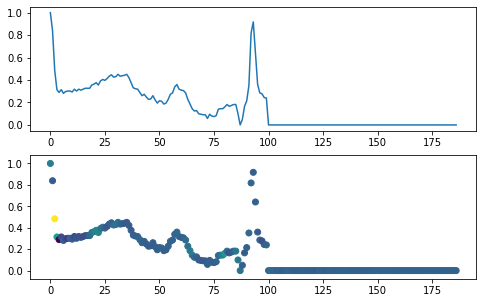

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
ax = axs[0]
ax.plot(np.arange(187), batch_inputs_by_class[0, 0, :])

ax = axs[1]
ax.scatter(x=np.arange(187), y=batch_inputs_by_class[0, 0, :], c=attributions_by_class[0, 0, :])

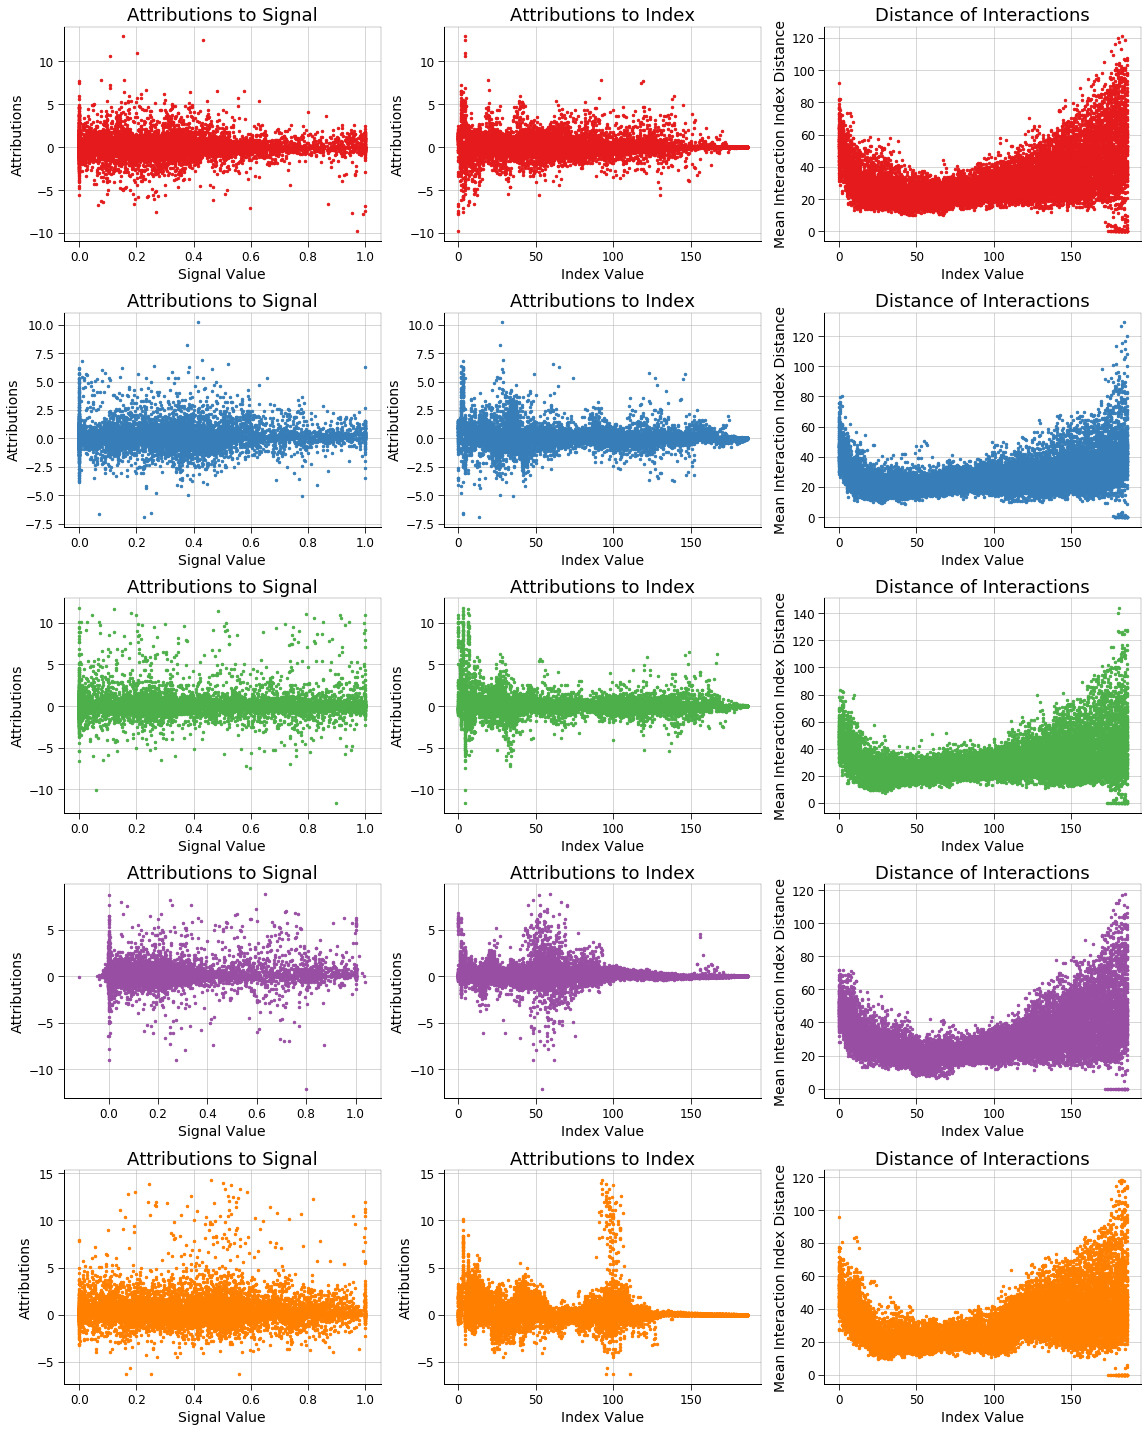

In [17]:
colors = plt.get_cmap('Set1')
fig, axs = plt.subplots(5, 3, figsize=(16, 20))

for i in range(5):
    ax = axs[i, 0]
    ax.scatter(x=batch_inputs_by_class[i].flatten(),
               y=attributions_by_class[i].flatten(),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Signal Value',
                   ylabel='Attributions',
                   title='Attributions to Signal')

    ax = axs[i, 1]
    ax.scatter(x=np.tile(np.expand_dims(np.arange(187), axis=0), reps=(100, 1)).flatten(),
               y=attributions_by_class[i].flatten(),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Index Value',
                   ylabel='Attributions',
                   title='Attributions to Index')

    ax = axs[i, 2]
    ax.scatter(x=np.tile(np.expand_dims(np.arange(187), axis=0), reps=(100, 1)).flatten(),
               y=np.sum(distance_matrix * (np.abs(zeroed_interactions_by_class[i]) / (np.expand_dims(np.sum(np.abs(zeroed_interactions_by_class[i]), axis=2), axis=2) + 0.00001)), axis=2),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Index Value',
                   ylabel='Mean Interaction Index Distance',
                   title='Distance of Interactions')

    interactions_by_class[0]

plt.tight_layout()

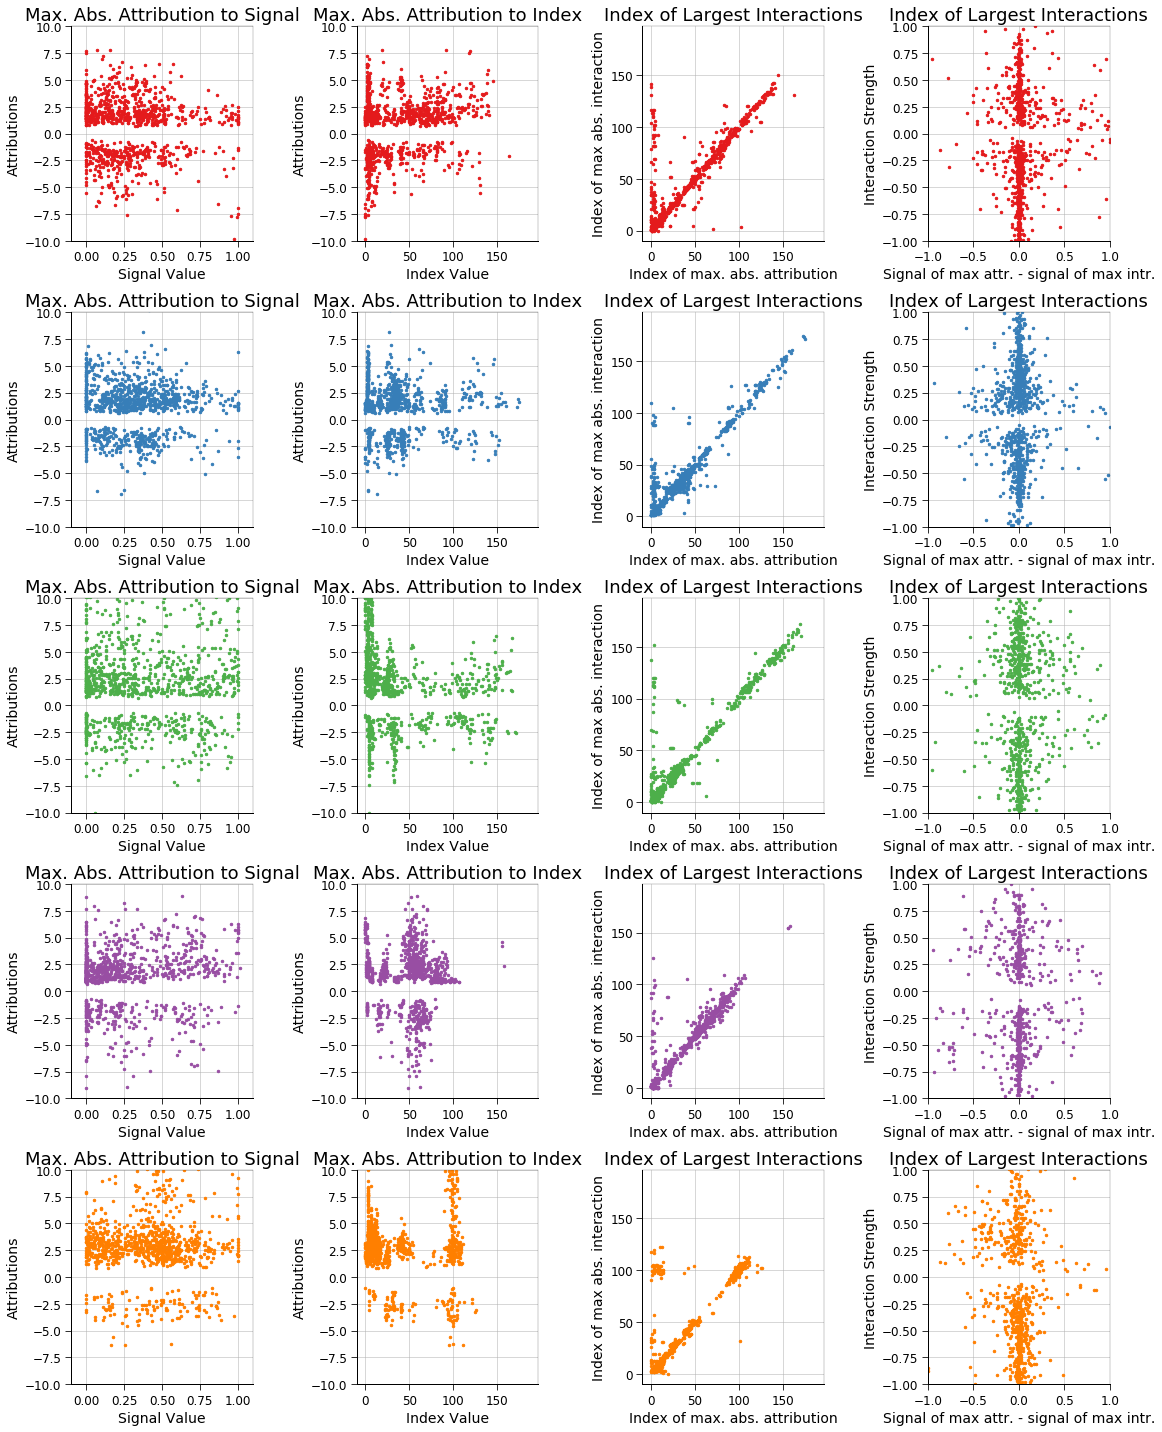

In [18]:
# colors = plt.get_cmap('Set1')
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

num_max = 10
for i in range(5):
    ax = axs[i, 0]

    tiled_indices = np.tile(np.expand_dims(np.arange(100), axis=1), reps=(1, num_max))
    max_attribution_index = np.argsort(np.abs(attributions_by_class[i]), axis=-1)[:, ::-1][:, :num_max]
    selected_interactions = zeroed_interactions_by_class[i, tiled_indices, max_attribution_index]
    max_interaction_index = np.argmax(np.abs(selected_interactions), axis=-1)

    index_matrix = np.tile(np.expand_dims(np.arange(187), axis=0), reps=(100, 1))

    signal_difference = batch_inputs_by_class[i, tiled_indices, max_attribution_index] - \
                        batch_inputs_by_class[i, tiled_indices, max_interaction_index]

    ax.scatter(x=batch_inputs_by_class[i, tiled_indices, max_attribution_index].flatten(),
               y=attributions_by_class[i, tiled_indices, max_attribution_index].flatten(),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Signal Value',
                   ylabel='Attributions',
                   title='Max. Abs. Attribution to Signal')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-10, 10)

    ax = axs[i, 1]
    ax.scatter(x=index_matrix[tiled_indices, max_attribution_index].flatten(),
               y=attributions_by_class[i, tiled_indices, max_attribution_index].flatten(),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Index Value',
                   ylabel='Attributions',
                   title='Max. Abs. Attribution to Index')
    ax.set_xlim(-10, 197)
    ax.set_ylim(-10, 10)

    ax = axs[i, 2]
    ax.scatter(x=index_matrix[tiled_indices, max_attribution_index].flatten(),
               y=index_matrix[tiled_indices, max_interaction_index].flatten(),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Index of max. abs. attribution',
                   ylabel='Index of max abs. interaction',
                   title='Index of Largest Interactions')
    ax.set_xlim(-10, 197)
    ax.set_ylim(-10, 197)

    ax = axs[i, 3]
    ax.scatter(x=signal_difference.flatten(),
               y=interactions_by_class[i, tiled_indices, max_attribution_index, max_interaction_index].flatten(),
               s=6,
               color=colors(i))
    customize_axis(ax,
                   xlabel='Signal of max attr. - signal of max intr.',
                   ylabel='Interaction Strength',
                   title='Index of Largest Interactions')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

plt.tight_layout()

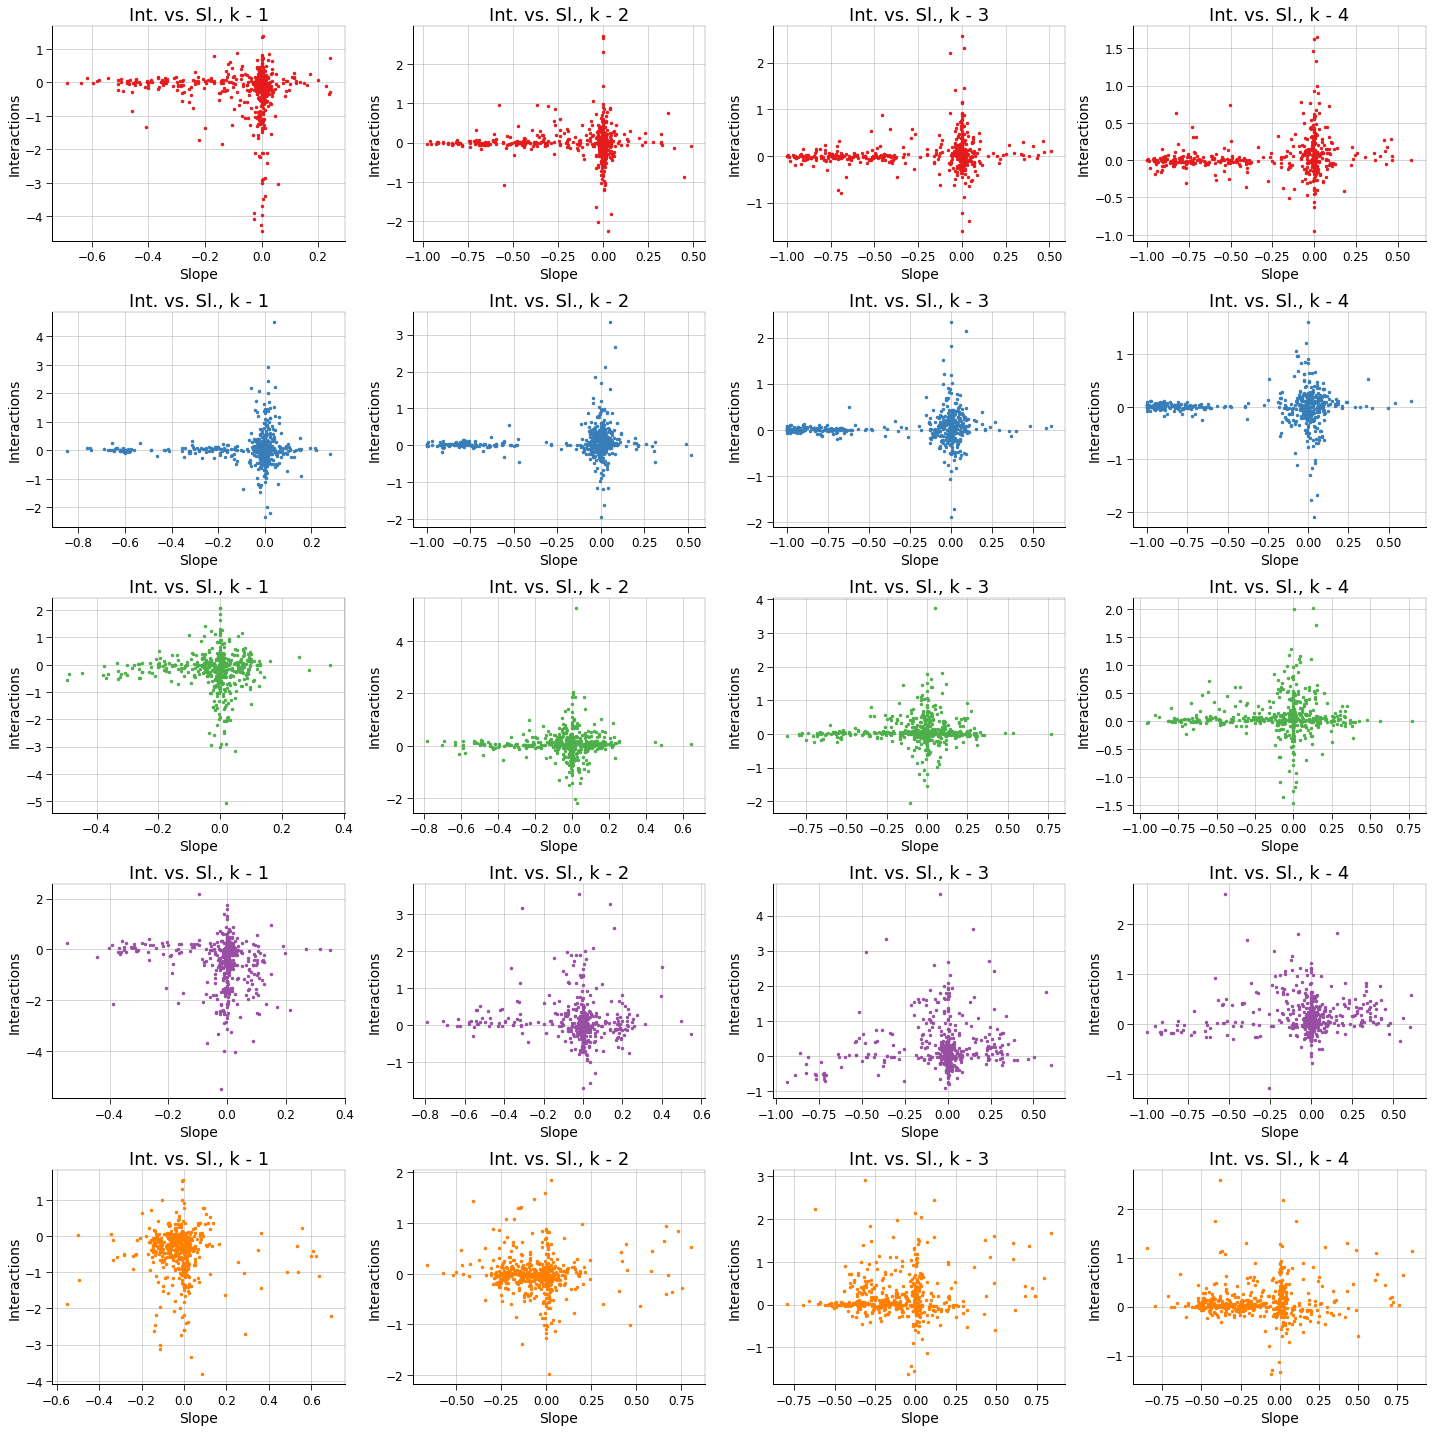

In [21]:
fig, axs = plt.subplots(5, 4, figsize=(20, 20))

num_max = 5
for i in range(5):
    for j in range(4):
        ax = axs[i, j]

        tiled_indices = np.tile(np.expand_dims(np.arange(100), axis=1), reps=(1, num_max))
        max_attribution_index = np.argsort(np.abs(attributions_by_class[i]), axis=-1)[:, ::-1][:, :num_max]
        previous_point_index  = np.maximum(max_attribution_index - j - 1, 0)
        signal_slope = batch_inputs_by_class[i, tiled_indices, max_attribution_index] - \
                       batch_inputs_by_class[i, tiled_indices, previous_point_index]

        ax.scatter(x=signal_slope.flatten(),
                   y=zeroed_interactions_by_class[i, tiled_indices, max_attribution_index, previous_point_index].flatten(),
                   s=6,
                   color=colors(i))
        customize_axis(ax,
                       xlabel='Slope',
                       ylabel='Interactions',
                       title='Int. vs. Sl., k - {}'.format(j + 1))
plt.tight_layout()

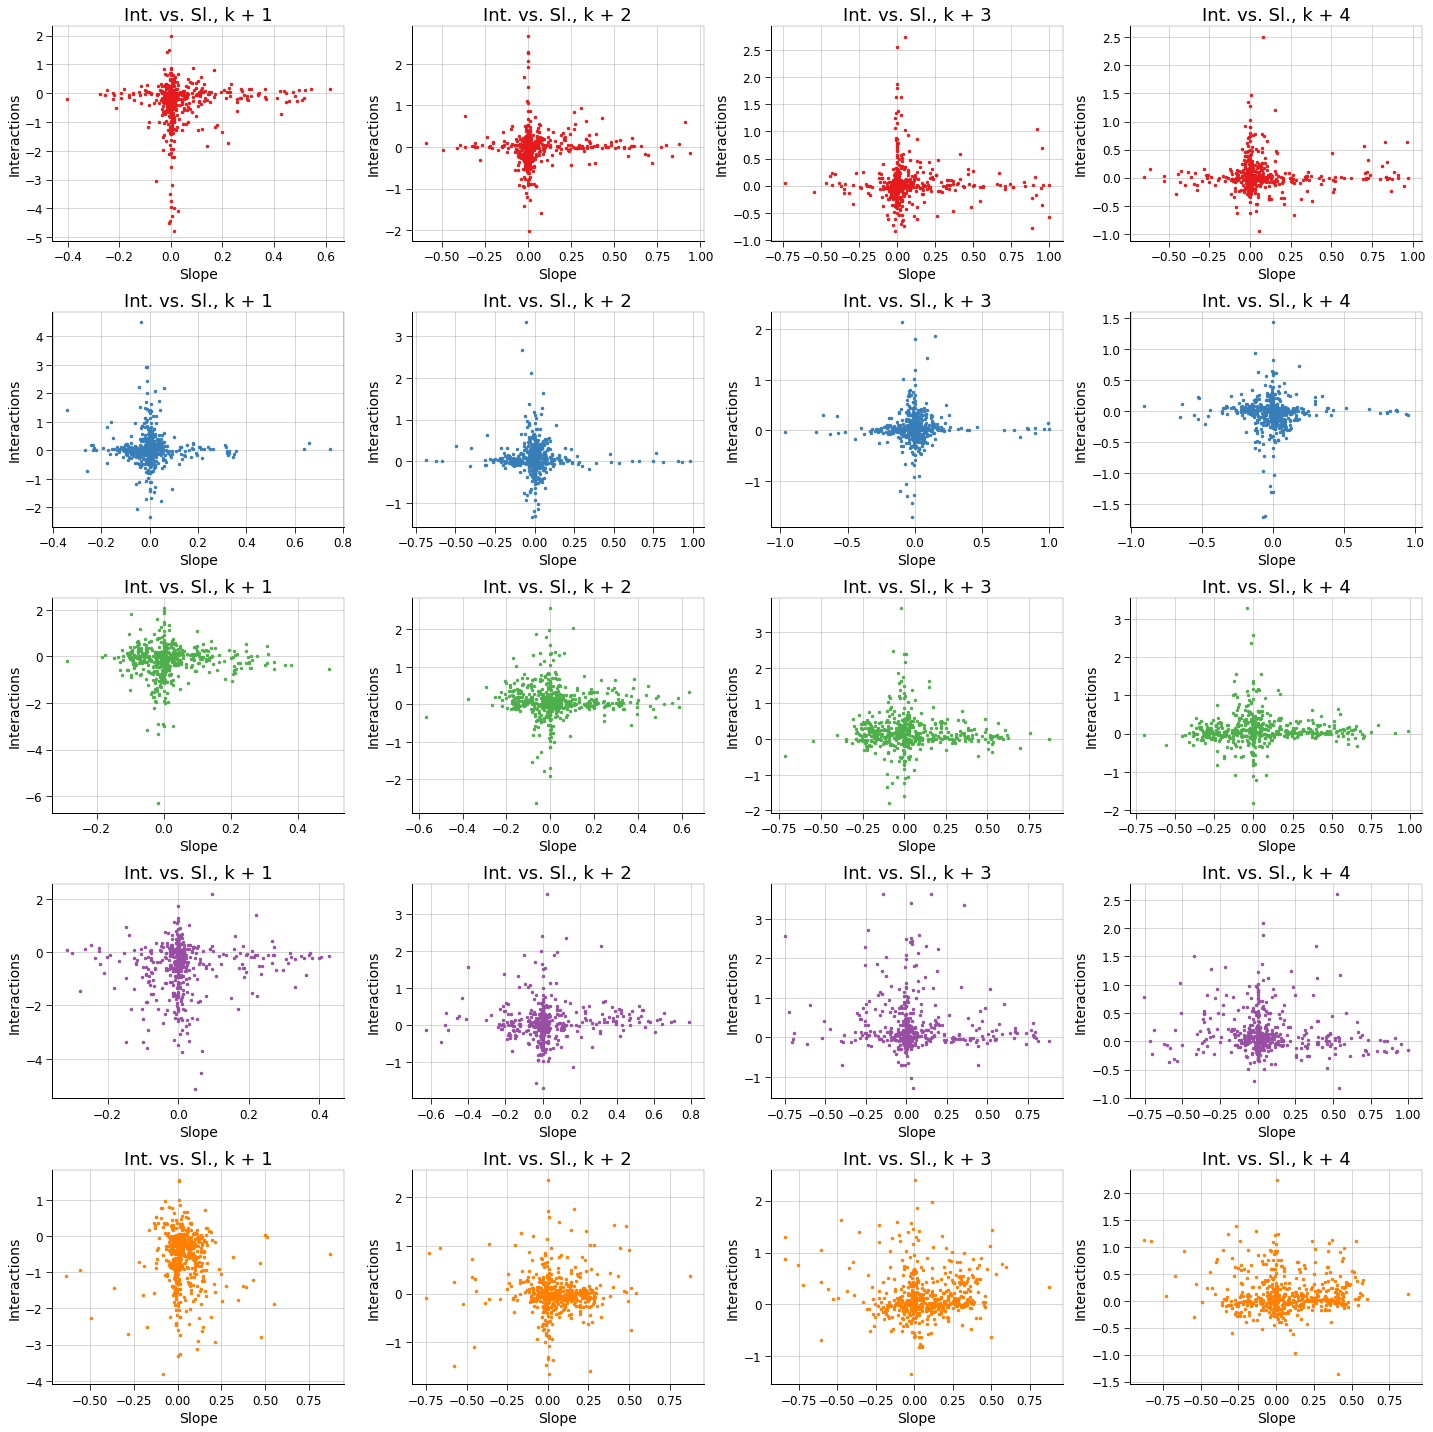

In [22]:
fig, axs = plt.subplots(5, 4, figsize=(20, 20))

for i in range(5):
    for j in range(4):
        ax = axs[i, j]

        tiled_indices = np.tile(np.expand_dims(np.arange(100), axis=1), reps=(1, num_max))
        max_attribution_index = np.argsort(np.abs(attributions_by_class[i]), axis=-1)[:, ::-1][:, :num_max]
        previous_point_index  = np.minimum(max_attribution_index + j + 1, 186)
        signal_slope = batch_inputs_by_class[i, tiled_indices, max_attribution_index] - \
                       batch_inputs_by_class[i, tiled_indices, previous_point_index]

        ax.scatter(x=signal_slope.flatten(),
                   y=zeroed_interactions_by_class[i, tiled_indices, max_attribution_index, previous_point_index].flatten(),
                   s=6,
                   color=colors(i))
        customize_axis(ax,
                       xlabel='Slope',
                       ylabel='Interactions',
                       title='Int. vs. Sl., k + {}'.format(j + 1))
plt.tight_layout()